# Logistic Regression with Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
from sklearn import metrics
from patsy import dmatrix, dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train =pd.read_csv('TitanicData/train.csv',sep=',',index_col='PassengerId')
df_test = pd.read_csv("TitanicData/test.csv",sep=',',index_col='PassengerId')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [5]:
# Function for cleaning and fill missing data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def clean_munge(df):
    df = df.drop(['Ticket','Cabin','Name'], axis=1)
    # The main part of passengers come from S so we fill with S.
    df.Embarked = df.Embarked.fillna('S')
    le.fit(df['Embarked'])
    x_emb=le.transform(df['Embarked'])
    df['Embarked']=x_emb.astype(np.float)
    # Fill empty values for age with median value. 
    df["AgeFill"] = df["Age"].fillna(df["Age"].median())
    # We transform Sex feature to integer value. 
    df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int64)
    # Remove the Name column Age and Sex (since I copied and filled it to AgeFill and Gender)
    df = df.drop(['Sex','Age'], axis=1) 
    return df

In [6]:
# Function for plotting coef of each feature
def plot_lr_coefs(X, lr):
    fig, ax = plt.subplots()
    xlabels = X.columns.values.tolist()
    yvalues = lr.coef_[0,]
    index = np.arange(len(yvalues))
    bar_width = 1
    opacity = 0.4
    rects = plt.bar(index, yvalues,bar_width, alpha=opacity,color='b',label="Plot of features")
    plt.ylabel('Values')
    plt.title('Features')
    plt.xticks(index, xlabels,rotation=45)
    plt.legend()
    plt.tight_layout()     

In [7]:
df_train_clean=clean_munge(df_train)
df_train_clean.head()

,Survived,Pclass,SibSp,Parch,Fare,Embarked,AgeFill,Gender
PassengerId,,,,,,,,
1,0,3,1,0,7.2500,2.0,22.0,1
2,1,1,1,0,71.2833,0.0,38.0,0
3,1,3,0,0,7.9250,2.0,26.0,0
4,1,1,1,0,53.1000,2.0,35.0,0
5,0,3,0,0,8.0500,2.0,35.0,1


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [9]:
#df_test["Fare"] = df_test["Fare"].fillna(df_test["Fare"].median())
df_test["Fare"] = df_test["Fare"].fillna(10)
df_test_clean=clean_munge(df_test)
df_test_clean.head()

,Pclass,SibSp,Parch,Fare,Embarked,AgeFill,Gender
PassengerId,,,,,,,
892,3,0,0,7.8292,1.0,34.5,1
893,3,1,0,7.0000,2.0,47.0,0
894,2,0,0,9.6875,1.0,62.0,1
895,3,0,0,8.6625,2.0,27.0,1
896,3,1,1,12.2875,2.0,22.0,0


In [10]:
df_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
Pclass      418 non-null int64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null float64
AgeFill     418 non-null float64
Gender      418 non-null int64
dtypes: float64(3), int64(4)
memory usage: 26.1 KB


In [11]:
formula2 = 'Fare+ SibSp + Parch+ C(Pclass)+ C(Gender)+ AgeFill+ C(Embarked)'

# First model quick and dirty :

In [12]:
formula1 = 'Fare+ SibSp + Parch'

In [13]:
y_train,X_train = dmatrices('Survived ~'+formula1+'-1',df_train_clean,return_type='dataframe')
print ("X_train cols=%s " % X_train.columns)
y_train = np.ravel(y_train)
clf = LogisticRegression()
model = clf.fit(X_train, y_train)

print ("Training score:%s" % model.score(X_train,y_train))
print ("Cross val score:%s" % cross_val_score(clf,X_train, y_train,scoring='accuracy',cv=5).mean())

X_test=dmatrix(formula1+'-1',df_test_clean)
predicted=model.predict(X_test)
print ("predicted:%s\n" % predicted[:5])    
print('intercept', model.intercept_)
print(pd.DataFrame(np.transpose(model.coef_),X_train.columns))

X_train cols=Index(['Fare', 'SibSp', 'Parch'], dtype='object') 
Training score:0.68125701459
Cross val score:0.674548857768
predicted:[ 0.  0.  0.  0.  0.]

intercept [-0.89755355]
              0
Fare   0.016249
SibSp -0.245615
Parch  0.155363


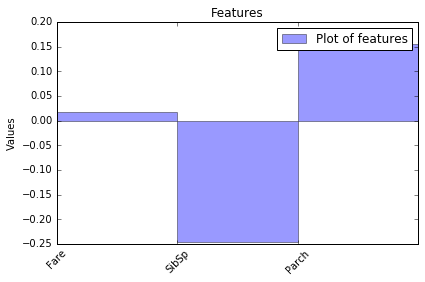

In [14]:
plot_lr_coefs(X_train,model)    

# A better model with more features :

In [15]:
formula2 = 'Fare+ SibSp + Parch+ C(Pclass)+ C(Gender)+ AgeFill+ C(Embarked)'

In [16]:
y_train,X_train = dmatrices('Survived ~'+formula2+'-1',df_train_clean,return_type='dataframe')
#The “-” sign can be used to remove columns/variables.
#For instance, we can remove the intercept from a model by: -1
print ("X_train cols=%s " % X_train.columns)
y_train = np.ravel(y_train)
clf = LogisticRegression()
model = clf.fit(X_train, y_train)

print ("Training score:%s" % model.score(X_train,y_train))
print ("Cross val score:%s" % cross_val_score(clf,X_train, y_train,scoring='accuracy',cv=5).mean())

X_test=dmatrix(formula2+'-1',df_test_clean)
predicted=model.predict(X_test)
print ("predicted:%s\n" % predicted[:5]) 

X_train cols=Index(['C(Pclass)[1]', 'C(Pclass)[2]', 'C(Pclass)[3]', 'C(Gender)[T.1]',
       'C(Embarked)[T.1.0]', 'C(Embarked)[T.2.0]', 'Fare', 'SibSp', 'Parch',
       'AgeFill'],
      dtype='object') 
Training score:0.806958473625
Cross val score:0.79354504436
predicted:[ 0.  0.  0.  0.  1.]



In [17]:
print(pd.DataFrame(np.transpose(model.coef_),X_train.columns))

                           0
C(Pclass)[1]        1.577805
C(Pclass)[2]        0.771687
C(Pclass)[3]       -0.377767
C(Gender)[T.1]     -2.545469
C(Embarked)[T.1.0]  0.041130
C(Embarked)[T.2.0] -0.338355
Fare                0.003275
SibSp              -0.297459
Parch              -0.074129
AgeFill            -0.033509


In [18]:
print('coef', model.coef_)
print('intercept', model.intercept_)

coef [[ 1.57780451  0.77168741 -0.37776669 -2.54546916  0.04112971 -0.33835545
   0.00327474 -0.29745865 -0.07412855 -0.03350934]]
intercept [ 1.97172523]


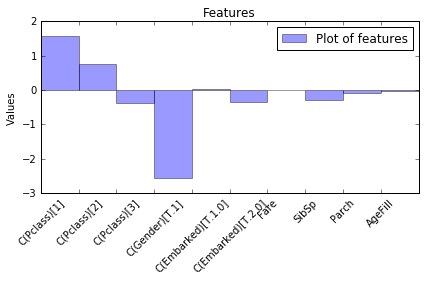

In [19]:
plot_lr_coefs(X_train,model)    

# With a new feature added: child

In [20]:
df_train_clean['is_child']=df_train_clean.AgeFill<8
df_test_clean['is_child']=df_test_clean.AgeFill<8
df_train_clean[:10]

,Survived,Pclass,SibSp,Parch,Fare,Embarked,AgeFill,Gender,is_child
PassengerId,,,,,,,,,
1,0,3,1,0,7.2500,2.0,22.0,1,False
2,1,1,1,0,71.2833,0.0,38.0,0,False
3,1,3,0,0,7.9250,2.0,26.0,0,False
4,1,1,1,0,53.1000,2.0,35.0,0,False
5,0,3,0,0,8.0500,2.0,35.0,1,False
6,0,3,0,0,8.4583,1.0,28.0,1,False
7,0,1,0,0,51.8625,2.0,54.0,1,False
8,0,3,3,1,21.0750,2.0,2.0,1,True
9,1,3,0,2,11.1333,2.0,27.0,0,False


In [21]:
formula3 = 'Fare+ SibSp + Parch+ C(Pclass)+ C(Gender)+ AgeFill+ C(Embarked)+C(is_child)'

In [22]:
y_train,X_train = dmatrices('Survived ~'+formula3+'-1',df_train_clean,return_type='dataframe')
print ("X_train cols=%s " % X_train.columns)
y_train = np.ravel(y_train)
clf = LogisticRegression()
model = clf.fit(X_train, y_train)

print ("Training score:%s" % model.score(X_train,y_train))
print ("Cross val score:%s" % cross_val_score(clf,X_train, y_train,scoring='accuracy',cv=5).mean())

X_test=dmatrix(formula3+'-1',df_test_clean)
predicted=model.predict(X_test)
print ("predicted:%s\n" % predicted[:5])  

X_train cols=Index(['C(Pclass)[1]', 'C(Pclass)[2]', 'C(Pclass)[3]', 'C(Gender)[T.1]',
       'C(Embarked)[T.1.0]', 'C(Embarked)[T.2.0]', 'C(is_child)[T.True]',
       'Fare', 'SibSp', 'Parch', 'AgeFill'],
      dtype='object') 
Training score:0.819304152637
Cross val score:0.812583539111
predicted:[ 0.  0.  0.  0.  0.]



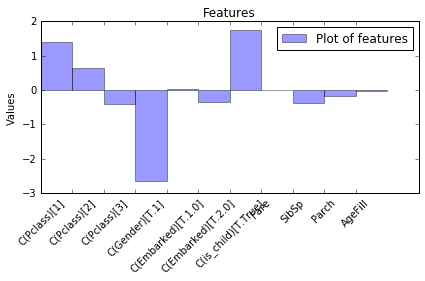

In [23]:
plot_lr_coefs(X_train,model)    

We can see immediately that the fact that it's a child is a feature with a big value for being a survival.

In [24]:
# Collect the test data's PassengerIds before dropping it
ids = df_test_clean.index.values

In [25]:
ids.shape

(418,)

In [26]:
predicted.shape

(418,)

In [27]:
predicted=predicted.astype(int)

In [28]:
a=zip(ids,predicted)

In [29]:
#Writing in a csv file
import csv as csv
predictions_file = open("myfirstTitanic.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, predicted))
predictions_file.close()